In [1]:
import time
start_simulation = time.time()

import os

import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp

import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.derivatives          as der
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.utilitis_FEEC.mass_matrices        as mass
import hylife.utilitis_FEEC.control_variate      as cv
import hylife.utilitis_FEEC.projectors_local     as proj

import hylife.geometry.mappings_old as maps # delete this later

In [2]:
# ========================================== parameters ==============================================================
Nel       = [32, 4, 4]             # mesh generation on logical domain
bc        = [True, True, True]     # boundary conditions (True: periodic, False: else)
p         = [3, 2, 2]              # spline degrees  


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
Ntot      =  NbaseN[0]*NbaseN[1]*NbaseN[2]                                     # total number of basis functions in V0


time_int  = True     # do time integration?
dt        = 0.06     # time step
Tend      = 0.8      # simulation time
max_time  = 60*60    # maximum runtime of program in minutes


# geometry (slab geometry)
kind_map  = 1
L         = [2*np.pi/0.75, 1., 1.]                                                     # box lengthes on physical domain

DF        = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])           # Jacobian matrix
DFinv     = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])           # inverse Jacobian matrix

G         = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])  # metric tensor
Ginv      = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])  # inverse metric tensor

g_sqrt    = L[0]*L[1]*L[2]                                                             # Jacobian determinant

mapping   = maps.mappings(['slab', L[0], L[1], L[2]])                                  # delete this later

# particle parameters
Np        = 128000              # total number of particles
vth       = 1.                  # thermal velocity of particles in all directions

v0x       = 2.5                 # mean velocity of hot ions in x-direction (must be compatible with backgound field)
v0y       = 0.                  # mean velocity of hot ions in y-direction (must be compatible with backgound field)
v0z       = 0.                  # mean velocity of hot ions in z-direction (must be compatible with backgound field)

nuh       = 0.05                # ratio of hot/bulk equlibrium number densities 

control   = 1                   # control variate? (0: no, 1: yes)

# particle loading
loading   = 'sobol_antithetic'  # 'pseudo-random': particles[:, :6] = np.random.rand(Np, 6)
                                # 'sobol_standard': particles[:, :6] = sobol.i4_sobol_generate(6, Np, 1000)
                                # 'sobol_antithetic': sobol.i4_sobol_generate(6, int(Np/64), 1000) --> 64 symmetric particles
                                # 'pr_space_uni_velocity': pseudo-random in space, uniform in velocity space
                                # 'external': particles[:, :6] = np.load('name_of_file.npy')
            
        
add_pressure = False            # add pressure (non-Hamiltonian) terms to simulation?
                           
            
            
# name and directory of output data file
#identifier  = 'STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_x_sobol_ref'
identifier  = 'STRUPHY_test_NEW'
dir_results = 'results/'


# Is this run a restart? If True, locate restart files
restart = False  

name_particles = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=particles1.npy'
name_rho_coeff = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=rho_coeff1.npy'
name_u_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=u_coeff1.npy'
name_b_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=b_coeff1.npy'
name_p_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=p_coeff1.npy'
name_control   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=CV1.npy'
name_time_step = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=time1.npy'


# Create restart files at the end of the simulation? If True, name full directory where to save them
create_restart = False
dir_restart    = '/home/florian/Desktop/PHD/02_Projekte/hylife/restart_files/' + identifier + '_restart_files/'
# =====================================================================================================================



# ===================== coefficients for pp-forms in interval [0, delta] (N and D) ====================================
pp0 = []
pp1 = []

for i in range(3):
    if p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    else:
        print('So far only cubic and quadratic splines implemented!')
# =====================================================================================================================



# ================================== background quantities for PIC ====================================================
Ueq_phys   = np.array([0., 0., 0.])     # background bulk flow (vector/1-form on physical domain)
Ueq        = DF.T.dot(Ueq_phys)         # background bulk flow (1-form on logical domain)


Beq_phys   = np.array([1., 0., 0.])     # background magnetic field (vector/2-form on physical domain)
Beq        = g_sqrt*DFinv.dot(Beq_phys) # background magnetic field (2-form on logical domain)

rhoeq_phys = 1. 
gamma      = 5/3                        # adiabatic exponent
# =====================================================================================================================


nh0_phys = rhoeq_phys*nuh                                    # hot ion number density on physical domain
nh0_123  = nh0_phys*g_sqrt                                   # hot ion number density on logical domain
Eh_eq    = nh0_123/2*(v0x**2 + v0y**2 + v0z**2 + 3*vth**2/2) # hot ion equilibrium energy

# initial hot ion distribution function (3-form on logical domain)
fh0             = lambda q1, q2, q3, vx, vy, vz : nh0_123/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# control variate
control_variate = lambda q1, q2, q3, vx, vy, vz : nh0_123/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# initial sampling distribution
g_sampling      = lambda q1, q2, q3, vx, vy, vz :       1/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)
# =====================================================================================================================

In [3]:
pro = proj.projectors_local_3d(T, p, bc)
cont = cv.terms_control_variate(T, p, bc, kind_map, L)
M1 = mass.mass_V1_3d(T, p, bc, [None, None], kind_map, L)

In [4]:
b1, b2, b3 = pro.PI_2([None, None, None], [5, 6, 7], kind_map, L)
u1, u2, u3 = pro.PI_1([lambda xi1, xi2, xi3 : np.zeros(xi1.shape), lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1), lambda xi1, xi2, xi3 : np.zeros(xi1.shape)])

In [5]:
J14_control = cont.inner_prod_V1_jh_eq(b1, b2, b3, kind_map, L)

In [6]:
J11_control = cont.mass_V1_nh_eq(b1, b2, b3, kind_map, L)

In [7]:
J14_control_coeff = sparse.linalg.spsolve(M1, np.concatenate((J14_control[0].flatten(), J14_control[1].flatten(), J14_control[2].flatten())))
J11_control_coeff = sparse.linalg.spsolve(M1, -J11_control.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten()))))

In [8]:
xiplot = np.linspace(0., 1., 200), np.array([0.5]), np.array([0.5])
J14_control_1, J14_control_2, J14_control_3 = eva.FEM_field_V1_3d([J14_control_coeff[0*Ntot:1*Ntot], J14_control_coeff[1*Ntot:2*Ntot], J14_control_coeff[2*Ntot:3*Ntot]], xiplot, T, p, bc)
J11_control_1, J11_control_2, J11_control_3 = eva.FEM_field_V1_3d([J11_control_coeff[0*Ntot:1*Ntot], J11_control_coeff[1*Ntot:2*Ntot], J11_control_coeff[2*Ntot:3*Ntot]], xiplot, T, p, bc)

Text(0,0.5,'$n_{h0}(U x B)_z$')

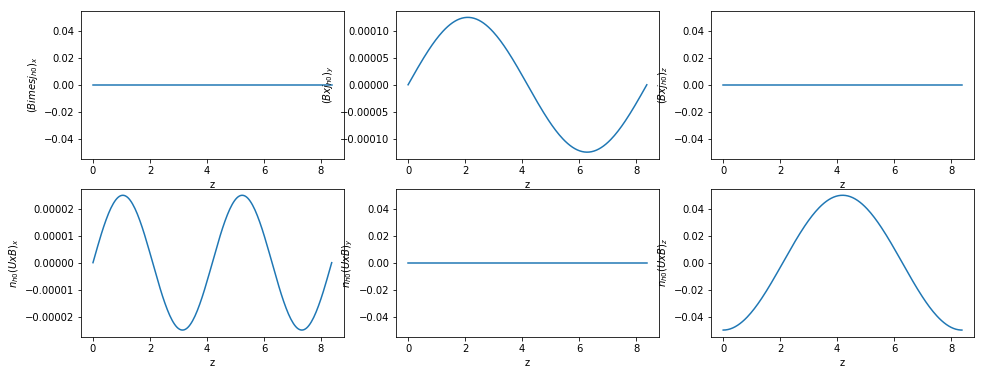

In [9]:
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(xiplot[0]*L[0], DFinv[0, 0]*J14_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B \times j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(xiplot[0]*L[0], DFinv[1, 1]*J14_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(xiplot[0]*L[0], DFinv[2, 2]*J14_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_z$')

plt.subplot(2, 3, 4)
plt.plot(xiplot[0]*L[0], DFinv[0, 0]*J11_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(xiplot[0]*L[0], DFinv[1, 1]*J11_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(xiplot[0]*L[0], DFinv[2, 2]*J11_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')